# Machine Learning Models with TF-IDF

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, mean_squared_error, r2_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE 

In [2]:
df = pd.read_csv('My_Vader_Data.csv')

In [3]:
# Assuming df is your DataFrame
columns_to_drop = ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0']
df = df.drop(columns=columns_to_drop, axis=1)

In [4]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID,consumer_narrative,Sentiment_Score,Sentiment_Label,Anger_Level
0,06/28/21,Checking or savings account,Checking account,Managing an account,Problem accessing account,I had to report my card stolen and report frau...,NaN,"Populus Financial Group, Inc. (F/K/A Ace Cash ...",UT,84088,...,Consent provided,Web,07/22/21,Closed with explanation,Yes,4499000,report card stolen report fraudulent activity ...,-0.5267,Negative,Angry
1,06/28/21,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,Dear wise.com is a wire transfer company. \nI ...,NaN,TransferWise Ltd,NaN,XXXXX,...,Consent provided,Web,07/14/21,Closed with explanation,Yes,4499207,dear wisecom wire transfer company tryed send ...,0.8289,Positive,Not Angry
2,06/27/21,Mortgage,FHA mortgage,Applying for a mortgage or refinancing an exis...,NaN,"I was reluctant to think this, but it felt as ...",NaN,Synovus Bank,GA,30101,...,Consent provided,Web,06/27/21,Closed with explanation,Yes,4494886,wa reluctant think felt though discriminated t...,0.9505,Positive,Not Angry
3,07/01/21,Debt collection,Credit card debt,Written notification about debt,Didn't receive enough information to verify debt,I am not liable for this debt with XXXX and I ...,Company believes the complaint provided an opp...,"Mountain Run Solutions, LLC",OH,44112,...,Consent provided,Web,07/01/21,Closed with explanation,Yes,4507730,liable debt contract mountain run solution plu...,0.2960,Positive,Not Angry
4,02/13/21,"Payday loan, title loan, or personal loan",Payday loan,Can't contact lender or servicer,NaN,A form was faxed to a doctor office in the sam...,NaN,Four Directions Lending LLC,MI,48227,...,Consent provided,Web,03/03/21,Closed with explanation,Yes,4138020,form wa faxed doctor office building work stat...,-0.8456,Negative,Furious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230339,11/01/21,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,I recently check my credit report due to me ow...,NaN,PORTFOLIO RECOVERY ASSOCIATES INC,NJ,07110,...,Consent provided,Web,11/01/21,Closed with explanation,Yes,4864559,recently check credit report due owning busine...,-0.9965,Negative,Seething
230340,10/05/21,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,XX/XX/2021 RE : Foreclosure Sale TS No : XXXX ...,NaN,Quality Loan Service Corporation,CA,92026,...,Consent provided,Web,10/05/21,Closed with explanation,Yes,4782618,foreclosure sale quality loan service corporat...,0.9932,Positive,Not Angry
230341,08/06/21,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,NaN,This is an amendment to compliant XXXX-XXXX. I...,NaN,JPMORGAN CHASE & CO.,NC,28803,...,Consent provided,Web,08/06/21,Closed with explanation,Yes,4608059,amendment compliant amending complaint add ema...,-0.8273,Negative,Furious
230342,03/25/21,Mortgage,Conventional home mortgage,Closing on a mortgage,NaN,I've outlined my complaint to the bank below. ...,NaN,JPMORGAN CHASE & CO.,NY,11104,...,Consent provided,Web,03/25/21,Closed with explanation,Yes,4247481,ive outlined complaint bank despite flurry act...,0.9983,Positive,Not Angry


In [5]:
def preprocess_data(df, n_gram_range=(1, 3), max_features=20, test_size=0.2, validation_size=0.2, random_state=42):
    # Ensure 'consumer_narrative' column is of string type
    df['consumer_narrative'] = df['consumer_narrative'].astype(str)

    # Label encode the Anger_Level column in the dataset
    le = LabelEncoder()
    df['Anger_Level_encoded'] = le.fit_transform(df['Anger_Level'])

    # Split data into features and target
    X = df['consumer_narrative']
    y = df['Anger_Level_encoded']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Further split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state)

    # TF-IDF vectorization with n-grams on training, validation, and testing data
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=n_gram_range)
    start_tfidf_time = time.time()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)
    X_test_tfidf = vectorizer.transform(X_test)
    end_tfidf_time = time.time()
    tfidf_vectorization_time = end_tfidf_time - start_tfidf_time

    # Prepare data for return without Word2Vec embeddings
    X_train_combined = X_train_tfidf.toarray()
    X_val_combined = X_val_tfidf.toarray()
    X_test_combined = X_test_tfidf.toarray()

    return X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le



In [6]:
# Preprocess the data
X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le = preprocess_data(df)

In [7]:
def train_and_evaluate_model(model, X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le, random_state=42, patience=3):
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=random_state)
    X_train_combined_res, y_train_res = smote.fit_resample(X_train_combined, y_train)

    # Define Stratified KFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Cross-validation loop with early stopping (using custom implementation)
    best_score = 0
    patience_counter = 0

    start_training_time = time.time()  # Start timing the training process

    # Convert y_train to a NumPy array
    y_train_array = np.array(y_train_res)

    for train_index, val_index in skf.split(X_train_combined_res, y_train_array):
        X_train_fold, X_val_fold = X_train_combined_res[train_index], X_train_combined_res[val_index]
        y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, y_val_pred, average='weighted')

        if f1 > best_score:
            best_score = f1
            best_model = model
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

    end_training_time = time.time()  # End timing the training process
    training_time = end_training_time - start_training_time

    print("Best Cross-Validation F1-score:", best_score)

    # Train the model on the entire training data
    best_model.fit(X_train_combined_res, y_train_res)

    # Predict encoded anger levels for test data
    start_prediction_time = time.time()
    y_pred = best_model.predict(X_test_combined)
    end_prediction_time = time.time()
    prediction_time = end_prediction_time - start_prediction_time

    # Evaluation
    print("F1-score (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print(classification_report(y_test, y_pred))

    # Confusion matrix with heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Anger Level (Encoded)')
    plt.ylabel('Actual Anger Level (Encoded)')
    plt.show()

    # ROC Curve and AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_combined)
    else:  # For models without predict_proba, use decision_function
        y_prob = model.decision_function(X_test_combined)
        y_prob = np.exp(y_prob) / np.sum(np.exp(y_prob), axis=1, keepdims=True)  # Softmax to convert to probabilities

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i, color in zip(range(len(le.classes_)), ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print training and prediction times
    print(f"TF-IDF Vectorization Time: {tfidf_vectorization_time:.4f} seconds")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Prediction Time: {prediction_time:.4f} seconds")

    # Compute and print MSE and R² score for training and validation sets
    y_train_pred = best_model.predict(X_train_combined_res)
    y_val_pred = best_model.predict(X_val_combined)

    train_mse = mean_squared_error(y_train_res, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train_res, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")


In [8]:
# Define models with class weights set to 'balanced'
log_reg_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
knn_model = KNeighborsClassifier()  # KNN does not have class_weight parameter
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=1)  # XGBoost does not use class_weight, use scale_pos_weight instead
lgbm_model = LGBMClassifier(random_state=42, class_weight='balanced')
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

Evaluating LogisticRegression
Best Cross-Validation F1-score: 0.3283359749512011
F1-score (weighted): 0.4605320792067392
              precision    recall  f1-score   support

           0       0.13      0.19      0.15      3779
           1       0.22      0.29      0.25      5440
           2       0.18      0.13      0.15      5380
           3       0.78      0.52      0.62     27579
           4       0.21      0.63      0.32      3891

    accuracy                           0.43     46069
   macro avg       0.31      0.35      0.30     46069
weighted avg       0.54      0.43      0.46     46069



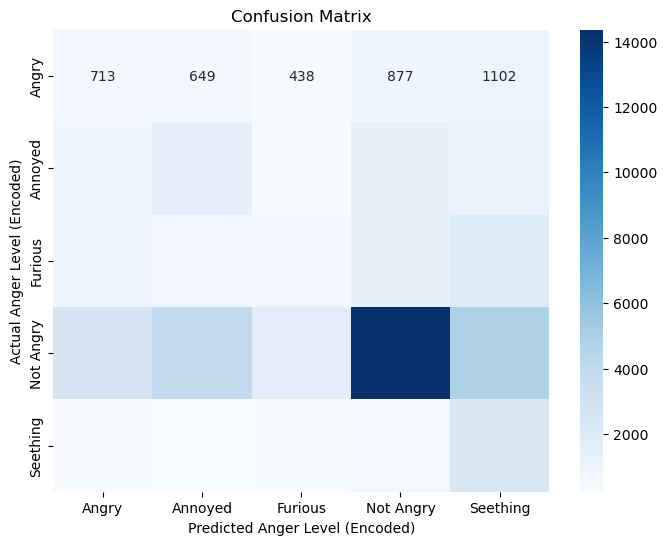

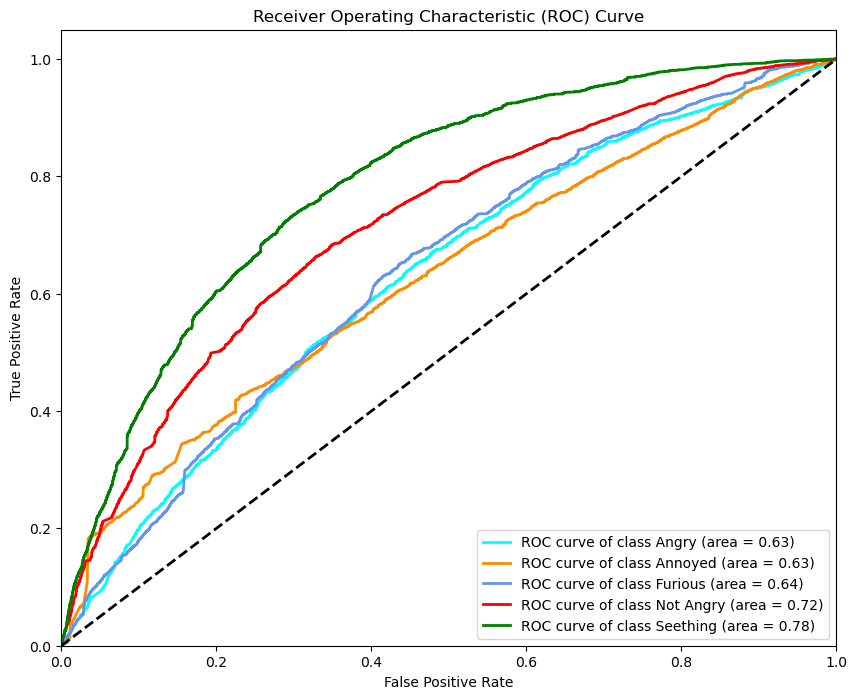

TF-IDF Vectorization Time: 81.9049 seconds
Training Time: 21.2671 seconds
Prediction Time: 0.0000 seconds
Validation MSE: 2.4380
Training R²: -0.6741
Validation R²: -1.1584


Evaluating RandomForestClassifier
Best Cross-Validation F1-score: 0.829235715902558
F1-score (weighted): 0.6518050513973338
              precision    recall  f1-score   support

           0       0.32      0.38      0.35      3779
           1       0.46      0.52      0.49      5440
           2       0.45      0.45      0.45      5380
           3       0.80      0.76      0.78     27579
           4       0.51      0.53      0.52      3891

    accuracy                           0.65     46069
   macro avg       0.51      0.53      0.52     46069
weighted avg       0.66      0.65      0.65     46069



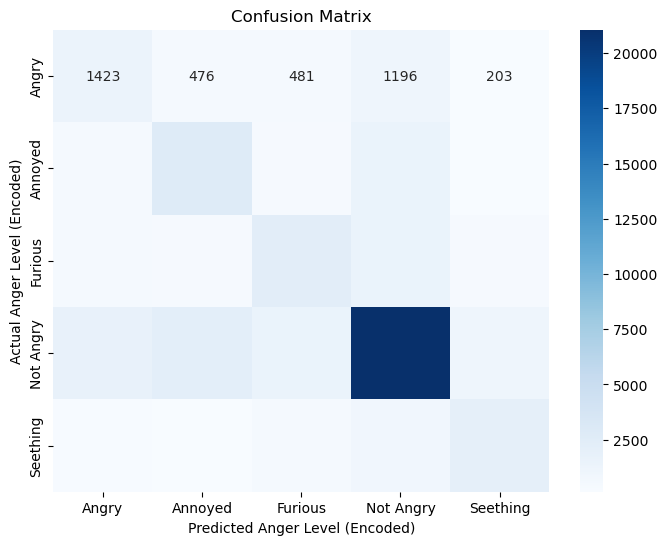

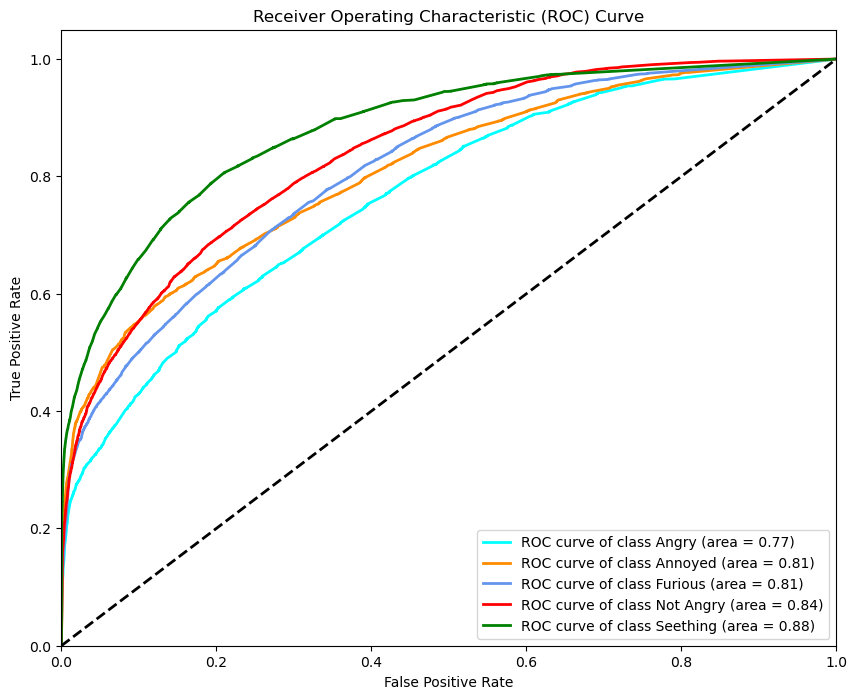

TF-IDF Vectorization Time: 81.9049 seconds
Training Time: 714.7790 seconds
Prediction Time: 1.4412 seconds
Validation MSE: 1.4039
Training R²: 0.8489
Validation R²: -0.2429


Evaluating KNeighborsClassifier
Best Cross-Validation F1-score: 0.7643515889364277
F1-score (weighted): 0.5464463995682277
              precision    recall  f1-score   support

           0       0.23      0.37      0.28      3779
           1       0.31      0.39      0.34      5440
           2       0.34      0.47      0.39      5380
           3       0.80      0.58      0.67     27579
           4       0.36      0.50      0.42      3891

    accuracy                           0.52     46069
   macro avg       0.41      0.46      0.42     46069
weighted avg       0.60      0.52      0.55     46069



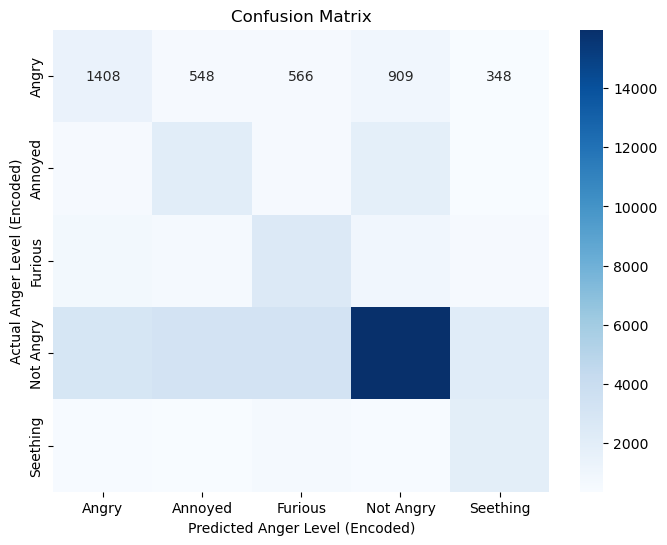

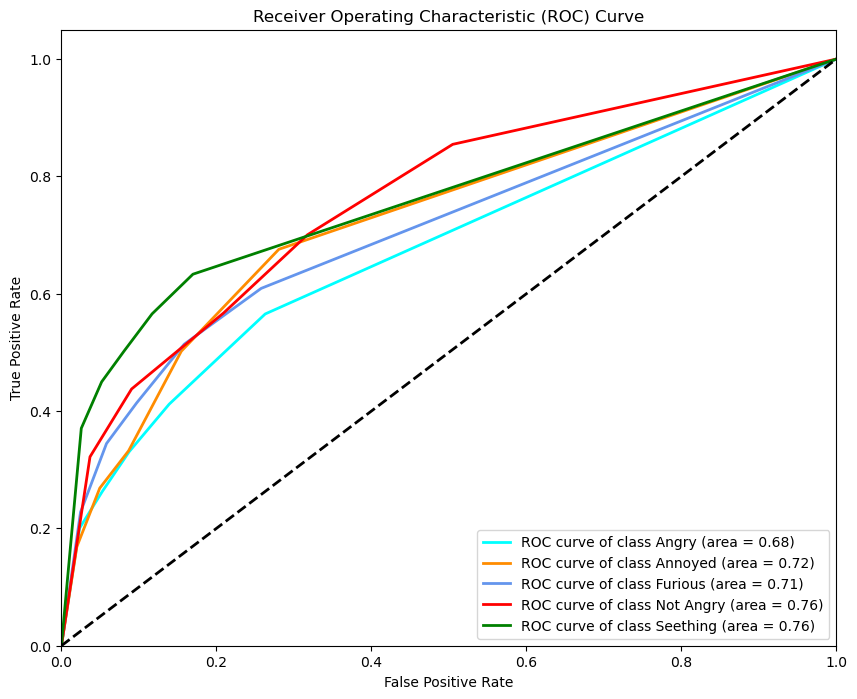

TF-IDF Vectorization Time: 81.9049 seconds
Training Time: 396.7931 seconds
Prediction Time: 53.4148 seconds
Validation MSE: 2.0603
Training R²: 0.5904
Validation R²: -0.8240


Evaluating DecisionTreeClassifier
Best Cross-Validation F1-score: 0.7170172541336572
F1-score (weighted): 0.5932297768430325
              precision    recall  f1-score   support

           0       0.25      0.41      0.31      3779
           1       0.37      0.55      0.44      5440
           2       0.38      0.46      0.41      5380
           3       0.82      0.64      0.72     27579
           4       0.43      0.46      0.44      3891

    accuracy                           0.57     46069
   macro avg       0.45      0.50      0.47     46069
weighted avg       0.64      0.57      0.59     46069



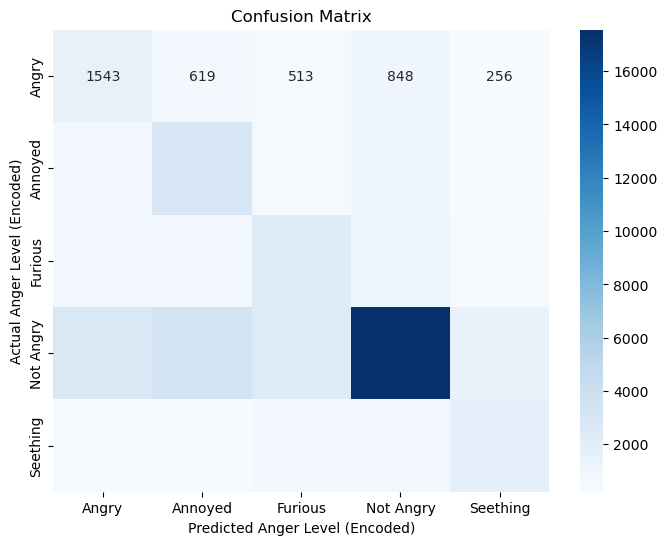

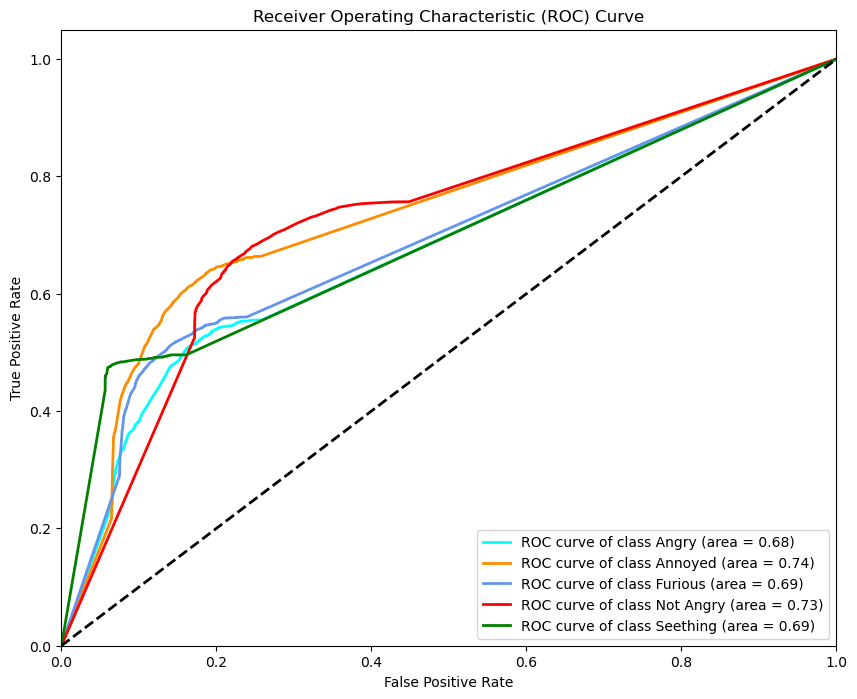

TF-IDF Vectorization Time: 81.9049 seconds
Training Time: 51.4771 seconds
Prediction Time: 0.0110 seconds
Validation MSE: 1.7687
Training R²: 0.8487
Validation R²: -0.5659


Evaluating XGBClassifier


C:\Users\pcudo\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pcudo\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pcudo\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pcudo\anaconda3\Lib\site-packages\xgb

Best Cross-Validation F1-score: 0.5717594074804252


C:\Users\pcudo\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


F1-score (weighted): 0.5912316526070733
              precision    recall  f1-score   support

           0       0.21      0.37      0.27      3779
           1       0.40      0.42      0.41      5440
           2       0.37      0.37      0.37      5380
           3       0.80      0.68      0.74     27579
           4       0.40      0.49      0.44      3891

    accuracy                           0.57     46069
   macro avg       0.44      0.47      0.44     46069
weighted avg       0.62      0.57      0.59     46069



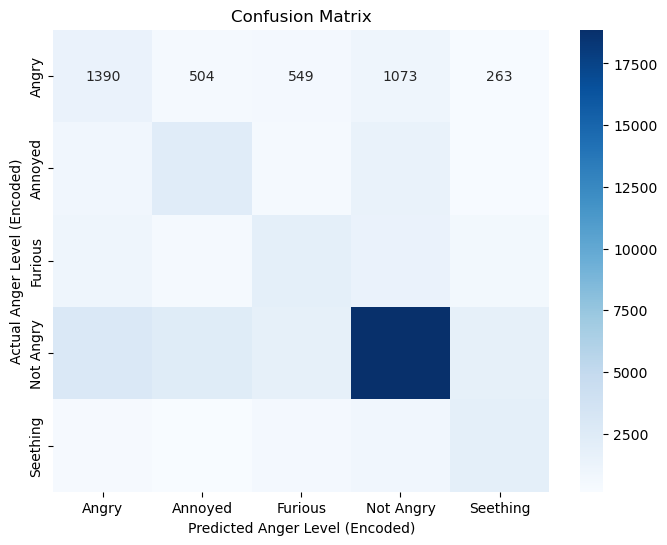

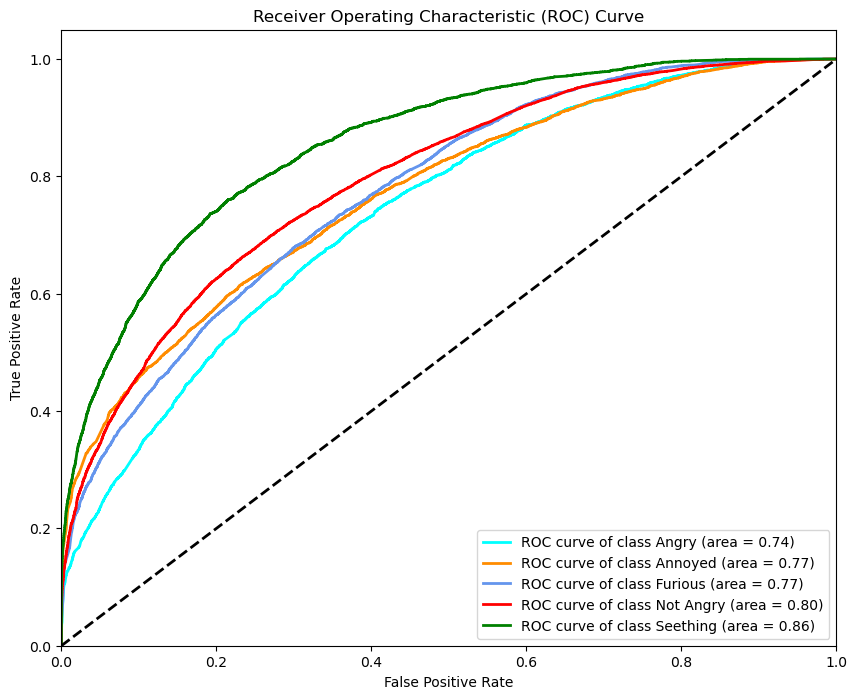

TF-IDF Vectorization Time: 81.9049 seconds
Training Time: 69.1617 seconds
Prediction Time: 0.1611 seconds
Validation MSE: 1.8121
Training R²: 0.0081
Validation R²: -0.6043


Evaluating LGBMClassifier
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 353124, number of used features: 20
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

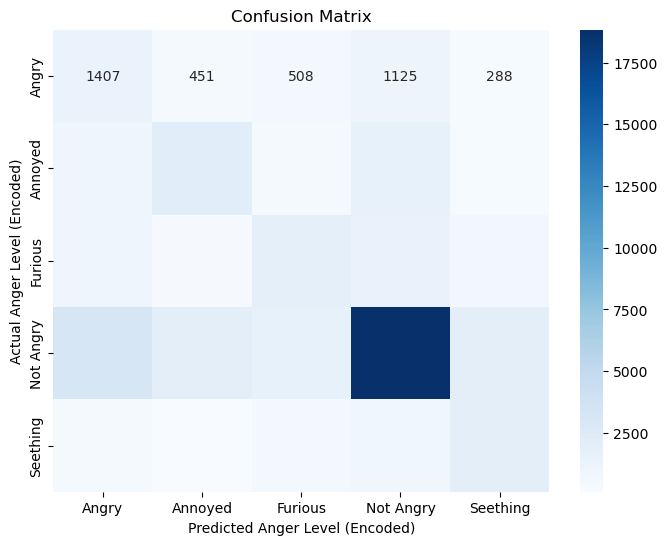

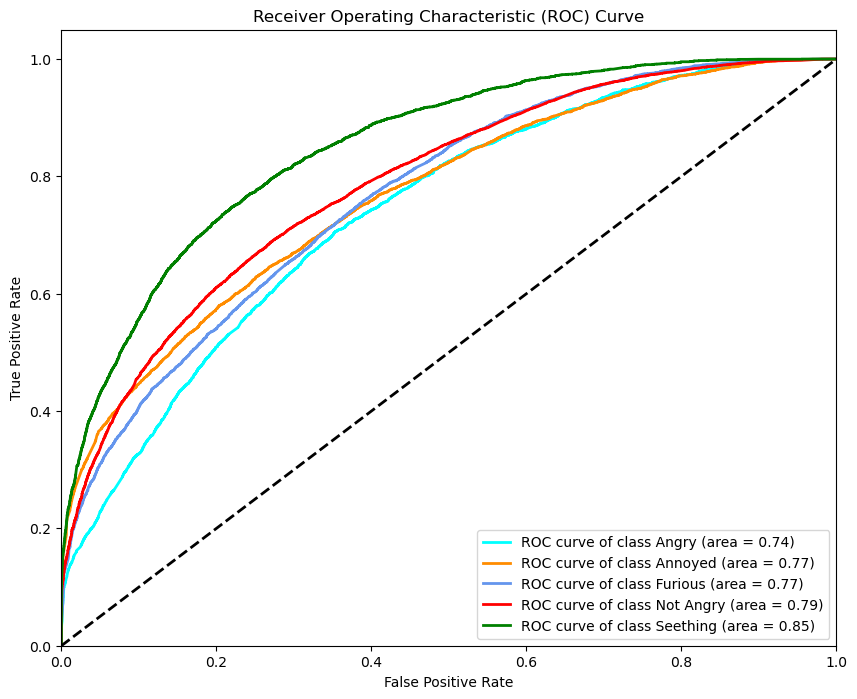

TF-IDF Vectorization Time: 81.9049 seconds
Training Time: 53.7881 seconds
Prediction Time: 0.5267 seconds
Validation MSE: 1.8917
Training R²: -0.1352
Validation R²: -0.6748


Evaluating CatBoostClassifier
Best Cross-Validation F1-score: 0.578074130170271
F1-score (weighted): 0.5879872417473546
              precision    recall  f1-score   support

           0       0.21      0.36      0.27      3779
           1       0.40      0.43      0.41      5440
           2       0.36      0.37      0.36      5380
           3       0.80      0.67      0.73     27579
           4       0.40      0.49      0.44      3891

    accuracy                           0.57     46069
   macro avg       0.43      0.47      0.44     46069
weighted avg       0.62      0.57      0.59     46069



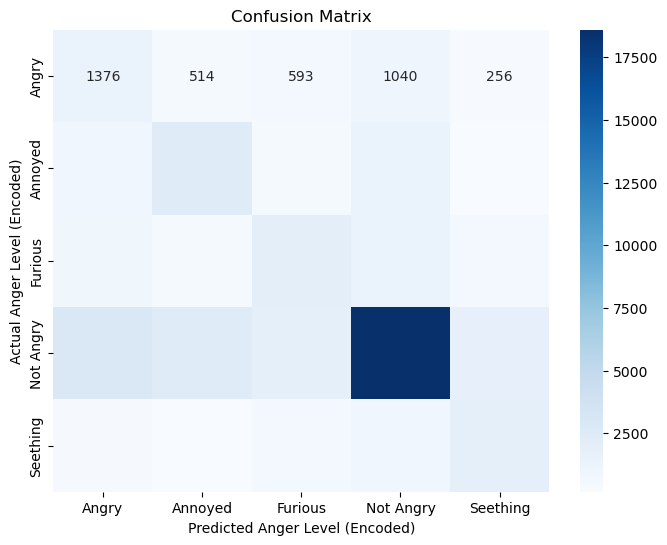

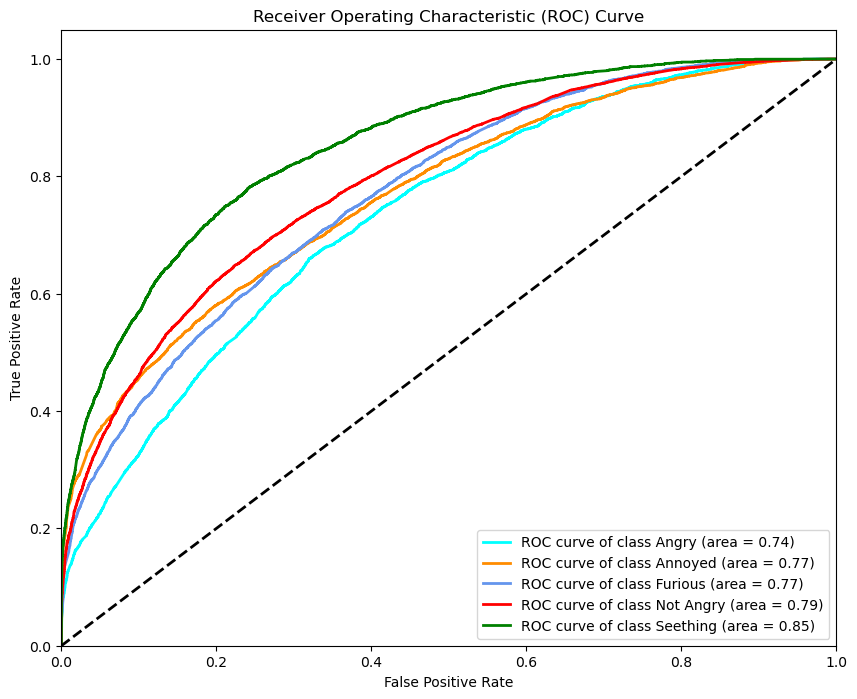

TF-IDF Vectorization Time: 81.9049 seconds
Training Time: 882.6062 seconds
Prediction Time: 0.4403 seconds
Validation MSE: 1.8128
Training R²: 0.0339
Validation R²: -0.6049




In [9]:
# Train and evaluate each model
models = [log_reg_model, rf_model, knn_model, dt_model, xgb_model, lgbm_model, catboost_model]

for model in models:
    print(f"Evaluating {model.__class__.__name__}")
    train_and_evaluate_model(model, X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le)
    print("\n" + "="*80 + "\n")


# Deep Learning Models (CNN, LSTM GRU)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import  KFold
from keras.layers import Input
from keras.callbacks import EarlyStopping

In [10]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(100, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, num_classes):
    model = Sequential([
        GRU(100, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [20]:
def train_and_evaluate_model(model, X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le, random_state=42, patience=3):
    # Reshape data if needed (for CNN, LSTM, GRU models)
    if len(X_train_combined.shape) == 3:
        X_train_combined = X_train_combined.reshape(X_train_combined.shape[0], -1)
        X_val_combined = X_val_combined.reshape(X_val_combined.shape[0], -1)
        X_test_combined = X_test_combined.reshape(X_test_combined.shape[0], -1)

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train_combined, y_train)

    # Convert y_train_res to categorical if needed
    if len(y_train_res.shape) == 1:
        y_train_res = to_categorical(y_train_res)

    # Convert y_val and y_test to categorical if needed
    y_val_cat = to_categorical(y_val)
    y_test_cat = to_categorical(y_test)

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Train the model
    start_training_time = time.time()
    history = model.fit(X_train_res, y_train_res, validation_data=(X_val_combined, y_val_cat), epochs=100, callbacks=[early_stopping], batch_size=32)
    end_training_time = time.time()
    training_time = end_training_time - start_training_time

    # Evaluate the model on the test set
    start_prediction_time = time.time()
    y_pred_prob = model.predict(X_test_combined)
    y_pred = np.argmax(y_pred_prob, axis=1)
    end_prediction_time = time.time()
    prediction_time = end_prediction_time - start_prediction_time

    # Evaluation
    print("F1-score (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print(classification_report(y_test, y_pred))

    # Confusion matrix with heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Anger Level (Encoded)')
    plt.ylabel('Actual Anger Level (Encoded)')
    plt.show()

    # ROC Curve and AUC
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i, color in zip(range(len(le.classes_)), ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print training and prediction times
    print(f"TF-IDF Vectorization Time: {tfidf_vectorization_time:.4f} seconds")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Prediction Time: {prediction_time:.4f} seconds")

    # Compute and print MSE and R² score for training and validation sets
    y_train_pred_prob = model.predict(X_train_combined)
    y_val_pred_prob = model.predict(X_val_combined)
    y_train_pred = np.argmax(y_train_pred_prob, axis=1)
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Training MSE: {train_mse:.4f}")
    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

C:\Users\pcudo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
C:\Users\pcudo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Evaluating CNN
Epoch 1/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.3887 - loss: 1.4128 - val_accuracy: 0.4839 - val_loss: 1.3227
Epoch 2/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.4532 - loss: 1.2991 - val_accuracy: 0.5251 - val_loss: 1.2408
Epoch 3/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.4743 - loss: 1.2599 - val_accuracy: 0.4206 - val_loss: 1.4340
Epoch 4/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.4871 - loss: 1.2324 - val_accuracy: 0.5544 - val_loss: 1.1749
Epoch 5/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.4962 - loss: 1.2122 - val_accuracy: 0.4980 - val_loss: 1.2736
Epoch 6/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.5023 - loss: 1.2018 - val_accuracy: 0.5559 - val_loss: 1.1692
Epoch 7/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.5069 - loss: 1.1914 - val_accuracy: 0.4875 - val_loss: 1.3056
Epoch 8/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 37

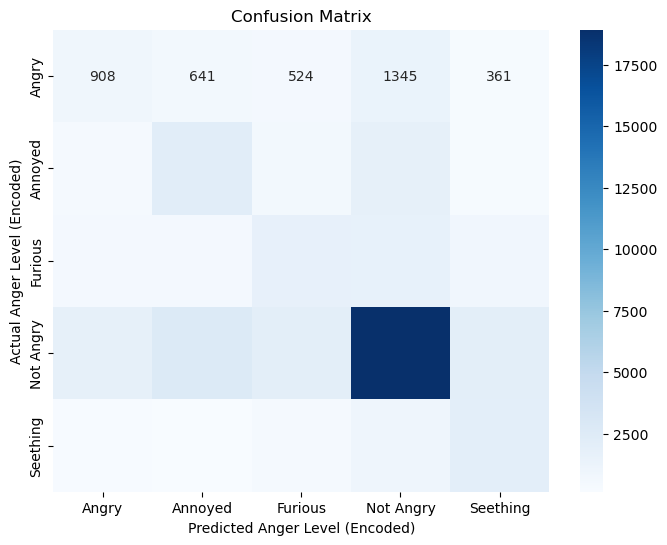

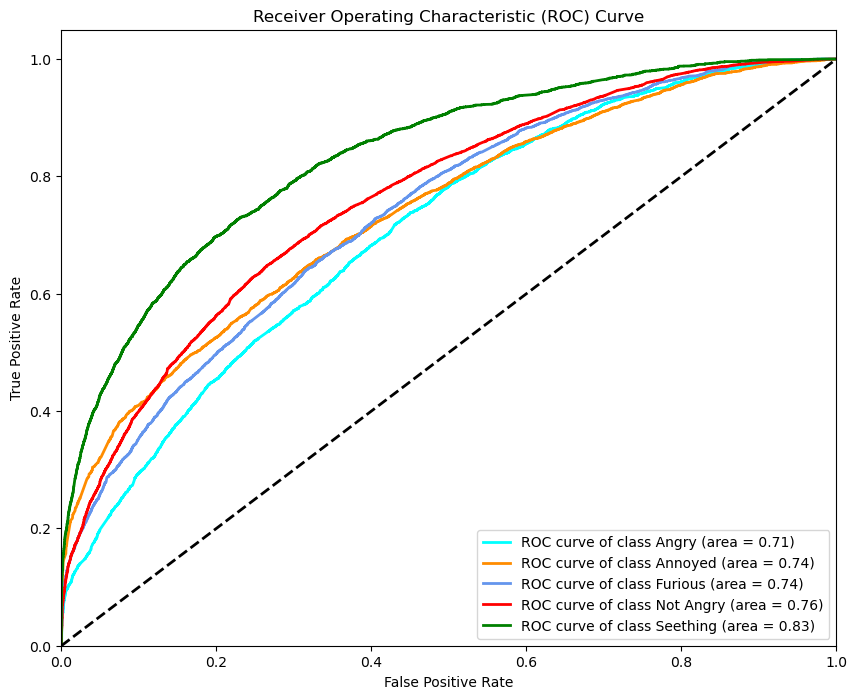

TF-IDF Vectorization Time: 81.9049 seconds
Training Time: 447.4122 seconds
Prediction Time: 3.0426 seconds
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training MSE: 1.6564
Validation MSE: 1.6817
Training R²: -0.4455
Validation R²: -0.4888


Evaluating LSTM
Epoch 1/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 151s 11ms/step - accuracy: 0.3148 - loss: 1.5125 - val_accuracy: 0.4082 - val_loss: 1.4162
Epoch 2/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 146s 11ms/step - accuracy: 0.4051 - loss: 1.3765 - val_accuracy: 0.4360 - val_loss: 1.3651
Epoch 3/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 147s 11ms/step - accuracy: 0.4495 - loss: 1.3008 - val_accuracy: 0.4910 - val_loss: 1.2587
Epoch 4/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 146s 11ms/step - accuracy: 0.4761 - loss: 1.2450 - val_accuracy: 0.4947 - val_loss: 1.2290
Epoch 5/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 147s 11ms/step - accuracy: 0.5022 - loss: 1.1940 - val_accuracy: 0.4768 - val_loss: 1.2774
Epoch 6/100
13794/137

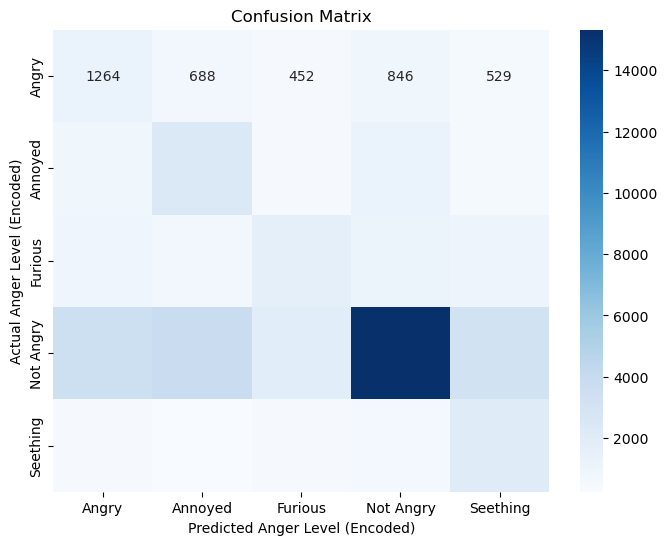

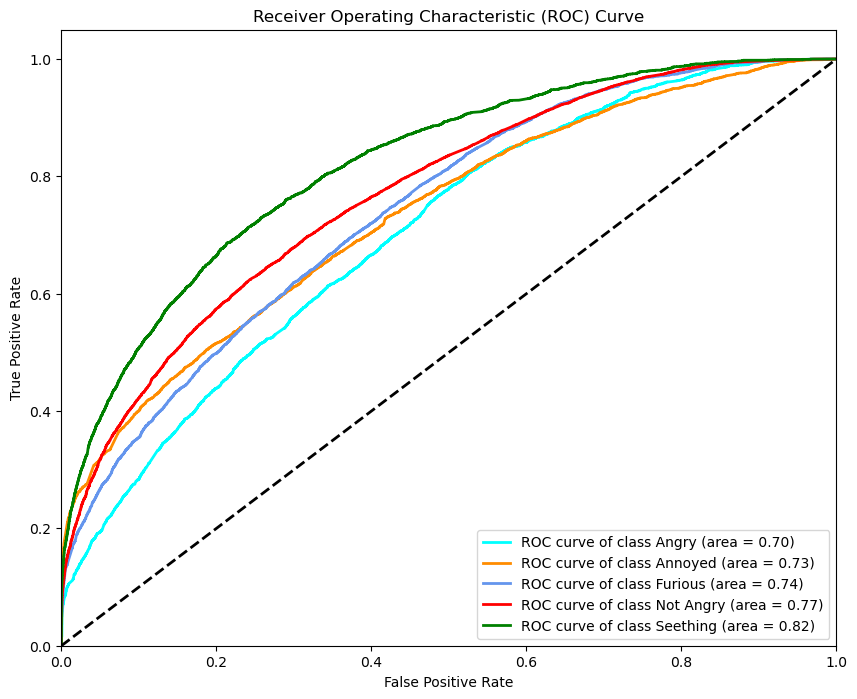

TF-IDF Vectorization Time: 81.9049 seconds
Training Time: 1037.4069 seconds
Prediction Time: 8.0479 seconds
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Training MSE: 2.1098
Validation MSE: 2.1885
Training R²: -0.8412
Validation R²: -0.9375


Evaluating GRU
Epoch 1/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 189s 13ms/step - accuracy: 0.3264 - loss: 1.5005 - val_accuracy: 0.4075 - val_loss: 1.4217
Epoch 2/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 172s 12ms/step - accuracy: 0.4126 - loss: 1.3648 - val_accuracy: 0.4501 - val_loss: 1.3160
Epoch 3/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 170s 12ms/step - accuracy: 0.4605 - loss: 1.2786 - val_accuracy: 0.4523 - val_loss: 1.3141
Epoch 4/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 170s 12ms/step - accuracy: 0.4925 - loss: 1.2164 - val_accuracy: 0.4485 - val_loss: 1.3262
Epoch 5/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 170s 12ms/step - accuracy: 0.5151 - loss: 1.1705 - val_accuracy: 0.4813 - val_loss: 1.2705
Epoch 6/100
13794/13

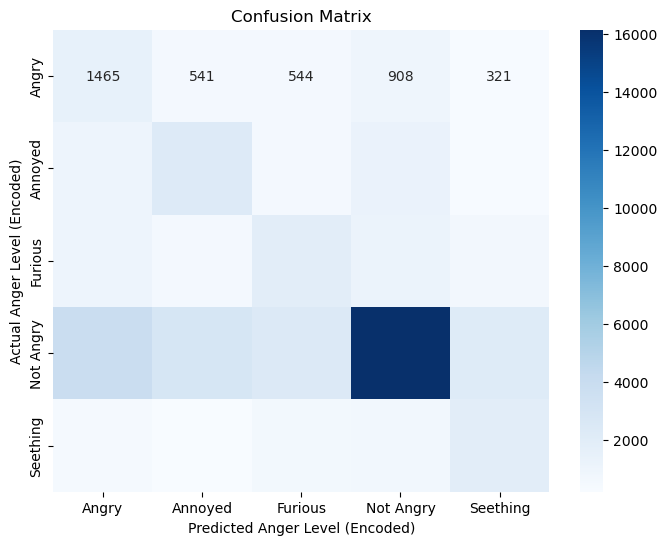

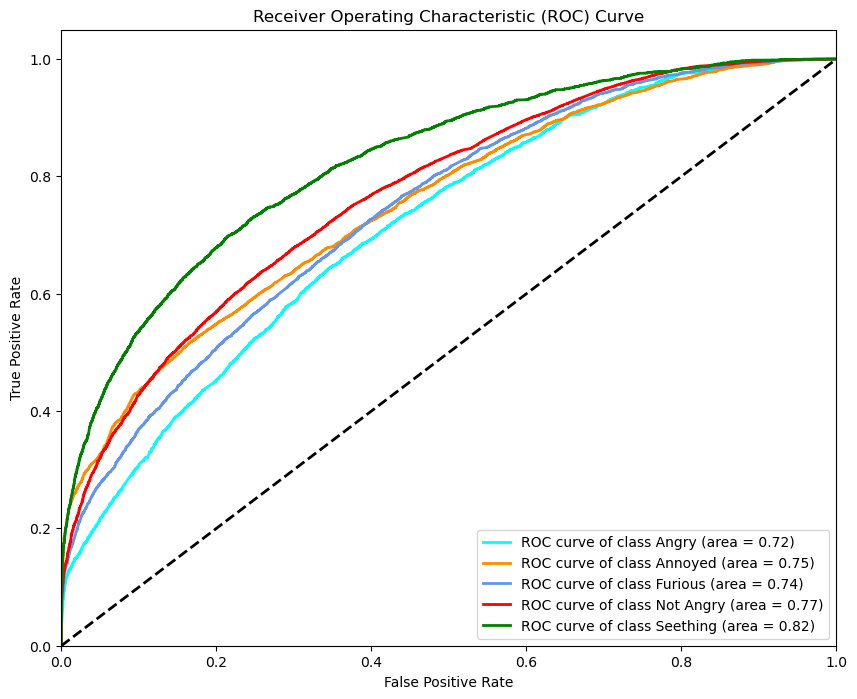

TF-IDF Vectorization Time: 81.9049 seconds
Training Time: 1561.3203 seconds
Prediction Time: 7.3190 seconds
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Training MSE: 1.9673
Validation MSE: 2.1426
Training R²: -0.7168
Validation R²: -0.8969




In [21]:
# Define the input shape and number of classes
input_shape = (X_train_combined.shape[1], 1)
num_classes = len(le.classes_)

# Reshape the data for CNN, LSTM, and GRU
X_train_combined = X_train_combined.reshape(X_train_combined.shape[0], X_train_combined.shape[1], 1)
X_val_combined = X_val_combined.reshape(X_val_combined.shape[0], X_val_combined.shape[1], 1)
X_test_combined = X_test_combined.reshape(X_test_combined.shape[0], X_test_combined.shape[1], 1)

# Build models
cnn_model = build_cnn_model(input_shape, num_classes)
lstm_model = build_lstm_model(input_shape, num_classes)
gru_model = build_gru_model(input_shape, num_classes)

# Train and evaluate each model
models = [cnn_model, lstm_model, gru_model]
model_names = ["CNN", "LSTM", "GRU"]

for model, name in zip(models, model_names):
    print(f"Evaluating {name}")
    train_and_evaluate_model(model, X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le)
    print("\n" + "="*80 + "\n")

